The strategy:

General condition: the stock price is above its 200-day MA

Buy decision if: 10-period RSI of the stock is below 30. We buy on the next day's open.

Sell decision if: 10-period RSI is above 40 or after 10 trading days. We sell on the next day's open.

Step 1: Calculating up and down moves: 

 Upmoves: 
   - take the daily return if return is positive
   - take 0 if daily return is negative or zero
   
Downmoves:
   - absolute value of daily return if return is negative
   - zero if return id positive or zero
   
   
Step 2: Averaging Up and Down moves
  
  1. Pick an average method (e.g. simple moving average or exponential moving average.
  2. We will take Wilder's smoothing method which id the same as expopnential moving average but with a different smoothing factor. Smoothing factor in exponential moving average: a = 2 / (N + 1), where N is a RSI period. Smoothing factor in Wilder's smoothing method: a = 1 / N.
  
As there is no WSM function in Python to get the WSM alpha of 1/10 we would have to use a N of 19 in the exponential moving average formula.

Step 3: RS and RSI calculation

  1. RS = Average Upmove / Average Downmove
  2. RSI = 100 - 100 / (1 + RS)
  


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [3]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [4]:
tickers

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [5]:
tickers = tickers.Symbol.tolist()

In [7]:
len(tickers)

505

In [9]:
tickers = [i.replace('.', '-') for i in tickers]

In [37]:
def RSI(asset):
         
    df = yf.download(asset, start='2011-01-01')
    
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()
    df['Return'] = df['Adj Close'].pct_change()
    
    df['Upmove'] = df['Return'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['Return'].apply(lambda x: abs(x) if x < 0 else 0)
    
    df['Average_up'] = df['Upmove'].ewm(span=19).mean()
    df['Average_down'] = df['Downmove'].ewm(span=19).mean()
    
    df = df.dropna()
    
    df['RS'] = df['Average_up'] / df['Average_down']
    df['RSI'] = df['RS'].apply(lambda x: 100 - (100 / (x + 1)))
    
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI'] < 30), 'Buy'] = 'Yes'
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI'] > 30), 'Buy'] = 'No'
    
    return df


def Get_signals(df):
    
    N_DAYS = 10 #Days we hold our position
    buying_dates = []
    selling_dates = []
    
    for i in range(len(df) - 11):
        if 'Yes' in df['Buy'].iloc[i]:
            buying_dates.append(df.iloc[i + 1].name)
            for j in range (1, 11):
                if df['RSI'].iloc[i + j] > 40:
                    selling_dates.append(df.iloc[i + j + 1].name)
                    break
                elif j == 10:
                    selling_dates.append(df.iloc[i + j + 1].name)
                    
    return buying_dates, selling_dates


In [30]:
frame = RSI(tickers[0])
buy, sell = Get_signals(frame)

[*********************100%***********************]  1 of 1 completed


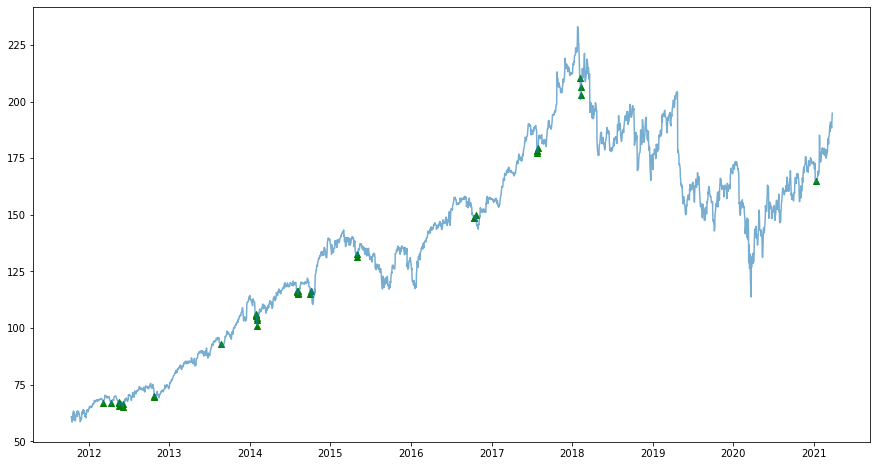

In [31]:
plt.figure(figsize=(15, 8))
plt.scatter(frame.loc[buy].index, frame.loc[buy]['Adj Close'], marker='^', c='g')
plt.plot(frame['Adj Close'], alpha=0.6)

In [32]:
profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values) / frame.loc[buy].Open.values

In [33]:
profits

array([ 0.01841858,  0.01323802, -0.0115183 , -0.01105814,  0.00212315,
        0.01287556,  0.03632401,  0.02847867,  0.01033357,  0.01558087,
        0.01012236, -0.00346098,  0.00108178, -0.00407378,  0.02345979,
        0.01052883,  0.02759942,  0.00556546,  0.00556546,  0.01286469,
        0.0062834 ,  0.01170129,  0.01861865,  0.01306246,  0.0130085 ,
        0.01320242, -0.00076654,  0.00355307, -0.01841872,  0.01366927,
        0.02033747,  0.01195283,  0.01595001,  0.00852711,  0.02154845,
        0.00861573,  0.01892706])

In [35]:
wins = [i for i in profits if i > 0]

In [36]:
len(wins) / len(profits)

0.8378378378378378

In [38]:
matrixsignals = []
matrixprofits = []

for i in range(len(tickers)):
    frame = RSI(tickers[i])
    buy, sell = Get_signals(frame)
    profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values) / frame.loc[buy].Open.values
    matrixsignals.append(buy)
    matrixprofits.append(profits)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

ValueError: cannot set a frame with no defined index and a scalar

In [40]:
len(matrixprofits)

490

In [41]:
allprofit = []

for i in matrixprofits:
    for e in i:
        allprofit.append(e)

In [42]:
wins = [i for i in allprofit if i > 0]


In [43]:
len(wins) / len(allprofit)

0.7150024053329668

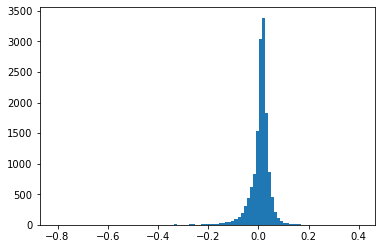

In [45]:
plt.hist(allprofit, bins=100)
plt.show()